\newpage

1. Using the UCI heart disease dataset, the project is trying to develop a predictive classification model to determine whether a patient has a heart problem based on 13 medical and demographical features. The response variable num, originally ranges from 0 to 4, is conveted to a binary variable that indicates the heart disease's presense. 0 represents no heart disease, and 1 (combining 1-4) represents its presense. Thus this project becomes a binary classification probelm with the objective of accurately predict the presense of heart disease.

In [1]:
#Load necessary libraries
!pip install matplotlib
!pip install seaborn

from ucimlrepo import fetch_ucirepo 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

df = pd.concat([heart_disease.data.features, heart_disease.data.targets], axis=1)

2. We applied one-hot encoding to all categorical variables to convert them into numerical form. Numerical features are standardized using z-score normalization. These transformations ensure that all input features are on the comparable scale, this is critically important to algorithms that are sensitive to feature magnitude. 

In [3]:
#2
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['num']]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Number of observations (rows): 303
Number of variables (columns): 21

Variable names and data types:
age          float64
trestbps     float64
chol         float64
thalach      float64
oldpeak      float64
num            int64
sex_1           bool
cp_2            bool
cp_3            bool
cp_4            bool
fbs_1           bool
restecg_1       bool
restecg_2       bool
exang_1         bool
slope_2         bool
slope_3         bool
ca_1.0          bool
ca_2.0          bool
ca_3.0          bool
thal_6.0        bool
thal_7.0        bool
dtype: object

Missing values:
age          0
trestbps     0
chol         0
thalach      0
oldpeak      0
num          0
sex_1        0
cp_2         0
cp_3         0
cp_4         0
fbs_1        0
restecg_1    0
restecg_2    0
exang_1      0
slope_2      0
slope_3      0
ca_1.0       0
ca_2.0       0
ca_3.0       0
thal_6.0     0
thal_7.0     0
dtype: int64

Descriptive statistics:
                age      trestbps          chol       thalach       oldpea

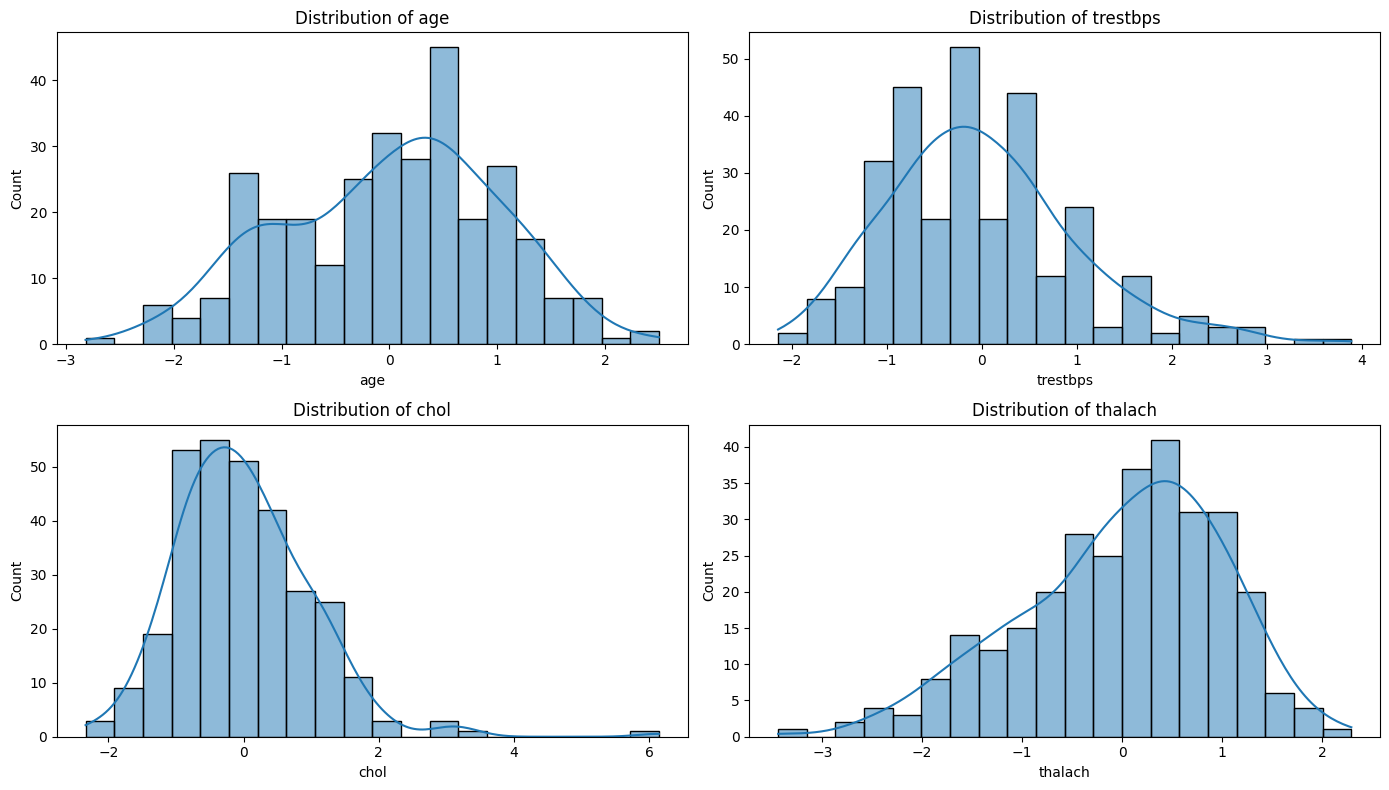

In [4]:
#3
print("Number of observations (rows):", df.shape[0])
print("Number of variables (columns):", df.shape[1])

print("\nVariable names and data types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

print("\nDescriptive statistics:")
print(df.describe())

#Show distribution
plt.figure(figsize=(14, 8))
vars_to_plot = ['age', 'trestbps', 'chol', 'thalach']
for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=20)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

The dataset has 303 observations and 14 variables.

Although all 14 variables are stored as `float64` due to the OpenML, not all of them are actually numerical in nature. Some of them just use numbers to represent different categories.
For example:
- Categorical variables: `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`, and `target`.  They are better understood as categorical, represent different groups or types rather than continuous values.
- Numerical variables: `age`, `trestbps`, `chol`, `thalach`, and `oldpeak` 
- The target variable (target) is binary:
1 indicates presence of heart disease, 0 indicates absence.
##### Observation：
- 1.There are no missing values in the dataset, so it can be used directly for modeling without any imputation.
- 2.The average patient age is around 54 years, with most patients between 40 and 65.
- 3.The cholesterol and resting blood pressure (trestbps) variables appear to be right-skewed, based on their histograms.

In [5]:
#4
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns='num', inplace=True)

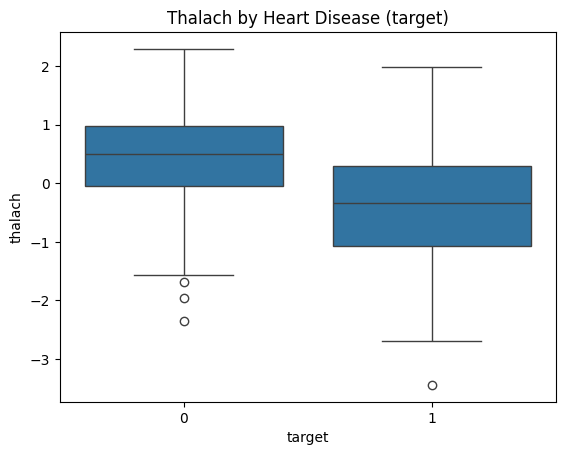

{'cp_2': np.float64(0.18), 'cp_3': np.float64(0.21), 'cp_4': np.float64(0.73)}


In [6]:
#5
# boxplot
sns.boxplot(data=df, x='target', y='thalach')
plt.title("Thalach by Heart Disease (target)")
plt.show()

# Groupby analysis: average heart disease rate by chest pain type
cp_target_means = {}

for col in ['cp_2', 'cp_3', 'cp_4']:
    mean_val = df[df[col] == 1]['target'].mean()
    cp_target_means[col] = round(mean_val, 2)  

print(cp_target_means)



##### Statement：
- Patients without heart disease (target = 0) tend to have higher maximum heart rates, while those with heart disease (target = 1) have lower values on average.
- We find that patients with `cp_4 = 1` have a much higher likelihood of having heart disease compared to those with other chest pain types. Therefore, chest pain type is a valuable predictor and should be retained as a feature during model training.

In [7]:
#6
df_dropped = df.dropna()
print("Number of observations after dropping rows with missing values:", df_dropped.shape[0])


Number of observations after dropping rows with missing values: 303


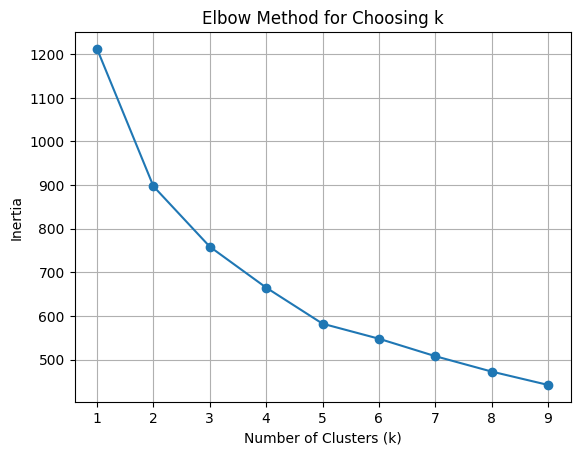

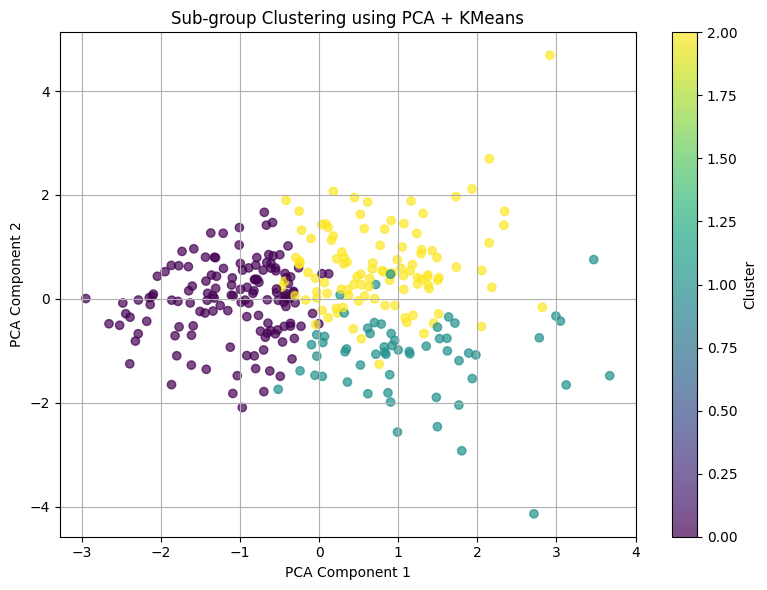

In [8]:
#7
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
categorical_dummies = [col for col in df.columns if any(cat in col for cat in categorical_cols)]

numerical_only = df.drop(columns=categorical_dummies + ['target'])

inertias = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(numerical_only)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Choosing k')
plt.grid(True)
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(numerical_only)

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(numerical_only)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("Sub-group Clustering using PCA + KMeans")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


Q7. 
In order to idtentify hidden sub-groups in the dataset, we first applied KMeans and used the elbow method to identify the best number of clusters. Since the inertia dropped sharply from K = 1 to K = 3, and the rate of change gradually slowed down afterwards, we chose K = 3 as the best number of clusters. 

 We then applied PCA to reduce the data into 2D for visualization. The plot showed 3 clear clusters, suggesting that the data contains inherent structure. Cluster 0 appears in the lower-right, Cluster 1 spreads out across the center-left, and Cluster 2 occupies the upper region. These groups likely represent patients with similar health profiles, for now we could not conclude the exact feature because we did not include labels. However, these groups might reflect different risk levels or clinical profiles, and further analysis may help to identity. 


In [9]:
#8
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Training set size: (212, 20)
Testing set size: (91, 20)


Q9.

For this assignment, I chose two classification models to compare: Logistic Regression and K-Nearest Neighbors (KNN).

- Logistic Regression: I picked Logistic Regression because it's a simple and reliable model for binary classification problems like predicting heart disease. It assumes a linear relationship between the input features and the outcome, which often works well in real-world data. It's also fast to train and the results are easy to understand, especially when looking at the feature weights.

- K-Nearest Neighbors (KNN): The second model I chose is K-Nearest Neighbors. I like this method because it's non-parametric and doesn’t require much training. Instead, it makes predictions by checking which nearby data points are most similar. This is helpful when the decision boundary isn’t straight or linear, and it’s pretty easy to understand how the model works just by thinking about "who’s nearby."

These two classifiers use very different approaches—one is linear and based on probabilities (logistic), and the other is distance-based and more flexible (KNN). I wanted to see how they perform on the same dataset and compare their strengths and weaknesses.
